### AIM: Determine best n_estimates & max_depth for RF in Boruta for each feature set

According to the creators of the BORUTA algorithm: “Normally default randomForest parameters are used, they will be sufficient in most cases since random forest performance has rather a weak dependence on its parameters. If it is not the case, one should try to find mtry and ntree for which random forest classifier achieves convergence at minimal value of the OOB error.” ("Feature Selection with the Boruta Package " (2010) by Kursa & Rudnicki)


In [1]:
from boruta import BorutaPy
import pandas as pd
import numpy as np
import mne
import pickle

from sklearn.ensemble import RandomForestClassifier

In [2]:
df_features = pd.read_pickle(r'D:\Documents\RU\Master_Neurobiology\Internship_jaar_2\Project\TD-BRAIN\TD-BRAIN_extracted_features\df_stat_features.pkl')
df_features['age'] = df_features['age'].round().astype('Int32') # round age to nearest year and convert to int
df_features = df_features.dropna(subset=['diagnosis'])
df_features.sample(7)

,ID,age,gender,diagnosis,epoch,EO_l_frontal_delta_std,EO_l_frontal_delta_mean,EO_l_frontal_delta_median,EO_l_frontal_delta_skew,EO_l_frontal_delta_kurt,...,ratio_m_posterior_gamma_std,ratio_m_posterior_gamma_mean,ratio_m_posterior_gamma_median,ratio_m_posterior_gamma_skew,ratio_m_posterior_gamma_kurt,ratio_r_posterior_gamma_std,ratio_r_posterior_gamma_mean,ratio_r_posterior_gamma_median,ratio_r_posterior_gamma_skew,ratio_r_posterior_gamma_kurt
729,sub-87969573,56,0.0,SMC,10,0.360852,-0.132081,-0.128107,-0.416488,-0.385803,...,1.087606,1.189084,1.159354,0.923646,0.517928,1.099464,1.175908,1.200257,1.089197,0.876337
7690,sub-88075769,67,0.0,MDD,11,0.385363,-0.157217,-0.158428,-0.217536,-0.513619,...,0.996802,0.987845,1.084019,1.164025,0.508840,1.044294,1.106699,1.225157,1.085565,3.496923
3707,sub-88038789,31,0.0,ADHD,12,0.466241,-0.211193,-0.220277,-0.480795,0.072896,...,0.892132,0.805394,0.974545,1.046836,1.278111,0.901694,0.820004,0.825246,1.010562,0.948239
4131,sub-88042969,49,1.0,MDD,4,0.354625,-0.124575,-0.120190,-0.640211,0.513811,...,0.959412,0.902465,0.874168,1.374870,4.300495,1.008302,1.012489,0.869424,0.972696,1.680554
6143,sub-88061729,59,0.0,MDD,12,0.315597,-0.107690,-0.109805,-0.470005,0.865730,...,0.939828,0.925273,0.982659,0.618737,-0.019445,0.976044,0.924582,0.930162,1.246167,1.526746
4316,sub-88044277,51,1.0,ADHD,9,0.361186,-0.125324,-0.129552,-0.772812,0.865533,...,1.001701,0.985818,1.037216,1.262720,3.247861,0.982207,0.946111,0.977441,1.372577,16.686110
4726,sub-88047517,61,0.0,MDD,11,0.442054,-0.208910,-0.208811,-0.195779,0.219048,...,1.045342,1.276753,1.309463,-0.010892,0.200227,1.218378,1.698248,1.792421,-0.144099,0.529424


In [3]:
# subsample dataset to rebalance dataset
df_ids = df_features[(df_features['epoch'] == 1)] # select only first epoch to make sure we subsample from participants, and not from epochs
df_ids_subsample = df_ids.groupby('diagnosis').sample(45, random_state=42) # sample 45 participants per diagnosis (which is the max for OCD)
df_ids_subsample_index = df_ids_subsample['ID'].tolist()
df_subsample = df_features[(df_features['ID'].isin(df_ids_subsample_index))]
df_subsample['diagnosis'].value_counts()

diagnosis
SMC        540
HEALTHY    540
MDD        540
ADHD       540
OCD        540
Name: count, dtype: int64

In [4]:
# create 3 feature sets [EC, EO, ratio] with column ['ID', 'age', 'gender', 'diagnosis', 'epoch']
df_features_ec = df_subsample[df_features.columns[~(df_subsample.columns.str.startswith('EO') | df_subsample.columns.str.startswith('ratio'))]]
df_features_eo = df_subsample[df_features.columns[~(df_subsample.columns.str.startswith('EC') | df_subsample.columns.str.startswith('ratio'))]]
df_features_ratio = df_subsample[df_features.columns[~(df_subsample.columns.str.startswith('EC') | df_subsample.columns.str.startswith('EO'))]]

# 1. statistical TFR features

### Ratio features

Visualization of OOB error rate vs RF hyperparameters

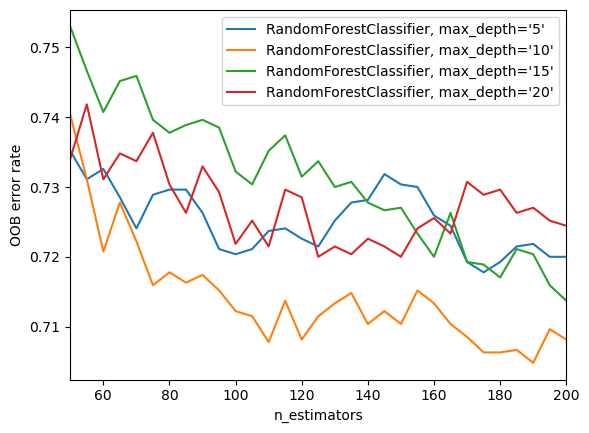

In [6]:
# Adjusted from:
# Author: Kian Ho <hui.kian.ho@gmail.com>
#         Gilles Louppe <g.louppe@gmail.com>
#         Andreas Mueller <amueller@ais.uni-bonn.de>
#
# License: BSD 3 Clause

from collections import OrderedDict
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

RANDOM_STATE = 123

# define numeric columns
numeric_cols = [num_col for num_col in df_features_ratio.columns if 'ratio' in num_col]
 
X = df_features_ratio[numeric_cols]
Y = df_features_ratio['diagnosis']

from sklearn.impute import SimpleImputer
imp_mean = SimpleImputer(missing_values=pd.NA, strategy='mean')
X = imp_mean.fit_transform(X)

from sklearn import preprocessing
le = preprocessing.LabelEncoder()
Y = le.fit_transform(Y)

# NOTE: Setting the `warm_start` construction parameter to `True` disables
# support for parallelized ensembles but is necessary for tracking the OOB
# error trajectory during training.
ensemble_clfs = [
    (
        "RandomForestClassifier, max_depth='5'",
        RandomForestClassifier(
            warm_start=True,
            oob_score=True,
            max_depth=5,
            random_state=RANDOM_STATE,
        ),
    ),
    (
        "RandomForestClassifier, max_depth='10'",
        RandomForestClassifier(
            warm_start=True,
            oob_score=True,
            max_depth=10,
            random_state=RANDOM_STATE,
        ),
    ),
    (
        "RandomForestClassifier, max_depth='15'",
        RandomForestClassifier(
            warm_start=True,
            oob_score=True,
            max_depth=15,
            random_state=RANDOM_STATE,
        ),
    ),
    (
        "RandomForestClassifier, max_depth='20'",
        RandomForestClassifier(
            warm_start=True,
            oob_score=True,
            max_depth=20,
            random_state=RANDOM_STATE,
        ),
    ),
    
]

# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

# Range of `n_estimators` values to explore.
min_estimators = 50
max_estimators = 200

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1, 5):
        clf.set_params(n_estimators=i)
        clf.fit(X, Y)

        # Record the OOB error for each `n_estimators=i` setting.
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))

# Generate the "OOB error rate" vs. "n_estimators" plot.
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
plt.show()

### EC features

Visualization of OOB error rate vs RF hyperparameters

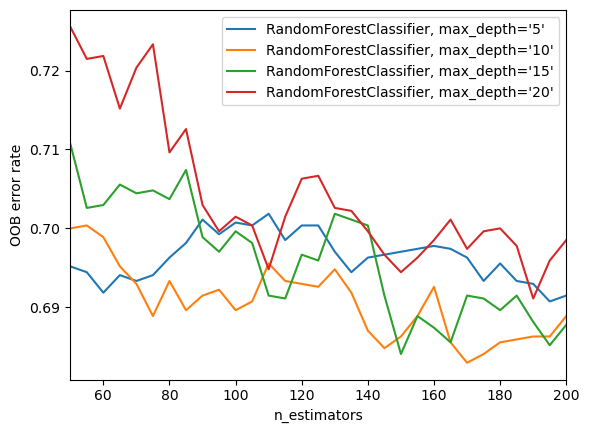

In [7]:
# Adjusted from:
# Author: Kian Ho <hui.kian.ho@gmail.com>
#         Gilles Louppe <g.louppe@gmail.com>
#         Andreas Mueller <amueller@ais.uni-bonn.de>
#
# License: BSD 3 Clause

from collections import OrderedDict
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

RANDOM_STATE = 123

# define numeric columns
numeric_cols = [num_col for num_col in df_features_ec.columns if 'EC' in num_col]
 
X = df_features_ec[numeric_cols]
Y = df_features_ec['diagnosis']

from sklearn.impute import SimpleImputer
imp_mean = SimpleImputer(missing_values=pd.NA, strategy='mean')
X = imp_mean.fit_transform(X)

from sklearn import preprocessing
le = preprocessing.LabelEncoder()
Y = le.fit_transform(Y)

# NOTE: Setting the `warm_start` construction parameter to `True` disables
# support for parallelized ensembles but is necessary for tracking the OOB
# error trajectory during training.
ensemble_clfs = [
    (
        "RandomForestClassifier, max_depth='5'",
        RandomForestClassifier(
            warm_start=True,
            oob_score=True,
            max_depth=5,
            random_state=RANDOM_STATE,
        ),
    ),
    (
        "RandomForestClassifier, max_depth='10'",
        RandomForestClassifier(
            warm_start=True,
            oob_score=True,
            max_depth=10,
            random_state=RANDOM_STATE,
        ),
    ),
    (
        "RandomForestClassifier, max_depth='15'",
        RandomForestClassifier(
            warm_start=True,
            oob_score=True,
            max_depth=15,
            random_state=RANDOM_STATE,
        ),
    ),
    (
        "RandomForestClassifier, max_depth='20'",
        RandomForestClassifier(
            warm_start=True,
            oob_score=True,
            max_depth=20,
            random_state=RANDOM_STATE,
        ),
    ),
    
]

# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

# Range of `n_estimators` values to explore.
min_estimators = 50
max_estimators = 200

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1, 5):
        clf.set_params(n_estimators=i)
        clf.fit(X, Y)

        # Record the OOB error for each `n_estimators=i` setting.
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))

# Generate the "OOB error rate" vs. "n_estimators" plot.
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
plt.show()

### EO features

Visualization of OOB error rate vs RF hyperparameters

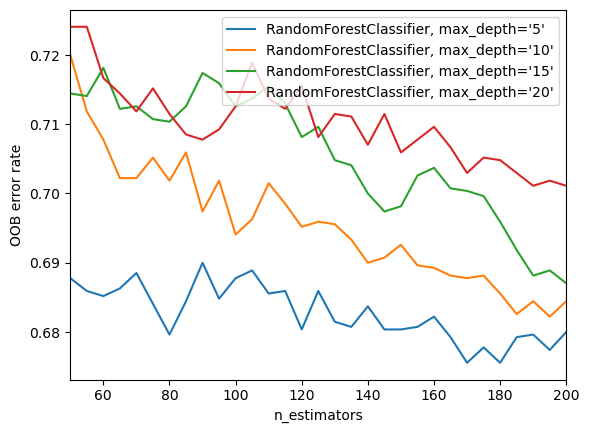

In [8]:
# Adjusted from:
# Author: Kian Ho <hui.kian.ho@gmail.com>
#         Gilles Louppe <g.louppe@gmail.com>
#         Andreas Mueller <amueller@ais.uni-bonn.de>
#
# License: BSD 3 Clause

from collections import OrderedDict
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

RANDOM_STATE = 123

# define numeric columns
numeric_cols = [num_col for num_col in df_features_eo.columns if 'EO' in num_col]
 
X = df_features_eo[numeric_cols]
Y = df_features_eo['diagnosis']

from sklearn.impute import SimpleImputer
imp_mean = SimpleImputer(missing_values=pd.NA, strategy='mean')
X = imp_mean.fit_transform(X)

from sklearn import preprocessing
le = preprocessing.LabelEncoder()
Y = le.fit_transform(Y)

# NOTE: Setting the `warm_start` construction parameter to `True` disables
# support for parallelized ensembles but is necessary for tracking the OOB
# error trajectory during training.
ensemble_clfs = [
    (
        "RandomForestClassifier, max_depth='5'",
        RandomForestClassifier(
            warm_start=True,
            oob_score=True,
            max_depth=5,
            random_state=RANDOM_STATE,
        ),
    ),
    (
        "RandomForestClassifier, max_depth='10'",
        RandomForestClassifier(
            warm_start=True,
            oob_score=True,
            max_depth=10,
            random_state=RANDOM_STATE,
        ),
    ),
    (
        "RandomForestClassifier, max_depth='15'",
        RandomForestClassifier(
            warm_start=True,
            oob_score=True,
            max_depth=15,
            random_state=RANDOM_STATE,
        ),
    ),
    (
        "RandomForestClassifier, max_depth='20'",
        RandomForestClassifier(
            warm_start=True,
            oob_score=True,
            max_depth=20,
            random_state=RANDOM_STATE,
        ),
    ),
    
]

# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

# Range of `n_estimators` values to explore.
min_estimators = 50
max_estimators = 200

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1, 5):
        clf.set_params(n_estimators=i)
        clf.fit(X, Y)

        # Record the OOB error for each `n_estimators=i` setting.
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))

# Generate the "OOB error rate" vs. "n_estimators" plot.
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
plt.show()

# 2. statistical TFR + connectivity features

In [9]:
df_conn_features = pd.read_pickle(r'D:\Documents\RU\Master_Neurobiology\Internship_jaar_2\Project\TD-BRAIN\TD-BRAIN_extracted_features\df_connectivity_features.pkl')
df_features = df_features.dropna(subset=['diagnosis'])

In [10]:
# subsample dataset to rebalance dataset
df_subsample = df_conn_features[(df_conn_features['ID'].isin(df_ids_subsample_index))] # use same sampled IDs from earlier for the stat features
df_subsample['diagnosis'].value_counts()

diagnosis
SMC        540
HEALTHY    540
MDD        540
ADHD       540
OCD        540
Name: count, dtype: int64

In [11]:
# create 3 feature sets [EC, EO, ratio] with column ['ID', 'age', 'gender', 'diagnosis', 'epoch']
df_conn_features_ec = df_subsample[df_conn_features.columns[~(df_subsample.columns.str.startswith('EO') | df_subsample.columns.str.startswith('ratio'))]]
df_conn_features_eo = df_subsample[df_conn_features.columns[~(df_subsample.columns.str.startswith('EC') | df_subsample.columns.str.startswith('ratio'))]]
df_conn_features_ratio = df_subsample[df_conn_features.columns[~(df_subsample.columns.str.startswith('EC') | df_subsample.columns.str.startswith('EO'))]]

In [12]:
# concat connectivity features with stat features
df_stat_conn_features_ec = pd.merge(df_features_ec, df_conn_features_ec.drop(columns=['diagnosis']),  how='outer', on=['ID', 'epoch'])
df_stat_conn_features_eo = pd.merge(df_features_eo, df_conn_features_eo.drop(columns=['diagnosis']),  how='outer', on=['ID', 'epoch'])
df_stat_conn_features_ratio = pd.merge(df_features_ratio, df_conn_features_ratio.drop(columns=['diagnosis']),  how='outer', on=['ID', 'epoch'])
print(df_stat_conn_features_ec.shape)



(2700, 410)


### Ratio features

Visualization of OOB error rate vs RF hyperparameters

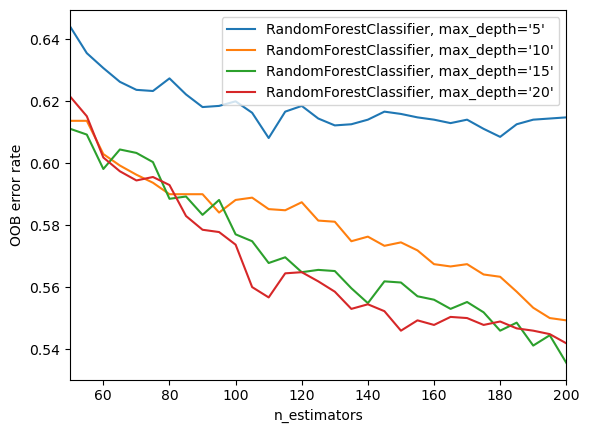

In [13]:
# Adjusted from:
# Author: Kian Ho <hui.kian.ho@gmail.com>
#         Gilles Louppe <g.louppe@gmail.com>
#         Andreas Mueller <amueller@ais.uni-bonn.de>
#
# License: BSD 3 Clause

from collections import OrderedDict
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

RANDOM_STATE = 123

numeric_cols = [num_col for num_col in df_stat_conn_features_ratio.columns if 'ratio' in num_col]
 
X = df_stat_conn_features_ratio[numeric_cols]
Y = df_stat_conn_features_ratio['diagnosis']

from sklearn.impute import SimpleImputer
imp_mean = SimpleImputer(missing_values=pd.NA, strategy='mean')
X = imp_mean.fit_transform(X)

from sklearn import preprocessing
le = preprocessing.LabelEncoder()
Y = le.fit_transform(Y)

# NOTE: Setting the `warm_start` construction parameter to `True` disables
# support for parallelized ensembles but is necessary for tracking the OOB
# error trajectory during training.
ensemble_clfs = [
    (
        "RandomForestClassifier, max_depth='5'",
        RandomForestClassifier(
            warm_start=True,
            oob_score=True,
            max_depth=5,
            random_state=RANDOM_STATE,
        ),
    ),
    (
        "RandomForestClassifier, max_depth='10'",
        RandomForestClassifier(
            warm_start=True,
            oob_score=True,
            max_depth=10,
            random_state=RANDOM_STATE,
        ),
    ),
    (
        "RandomForestClassifier, max_depth='15'",
        RandomForestClassifier(
            warm_start=True,
            oob_score=True,
            max_depth=15,
            random_state=RANDOM_STATE,
        ),
    ),
    (
        "RandomForestClassifier, max_depth='20'",
        RandomForestClassifier(
            warm_start=True,
            oob_score=True,
            max_depth=20,
            random_state=RANDOM_STATE,
        ),
    ),
    
]

# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

# Range of `n_estimators` values to explore.
min_estimators = 50
max_estimators = 200

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1, 5):
        clf.set_params(n_estimators=i)
        clf.fit(X, Y)

        # Record the OOB error for each `n_estimators=i` setting.
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))

# Generate the "OOB error rate" vs. "n_estimators" plot.
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
plt.show()

### EC features

Visualization of OOB error rate vs RF hyperparameters

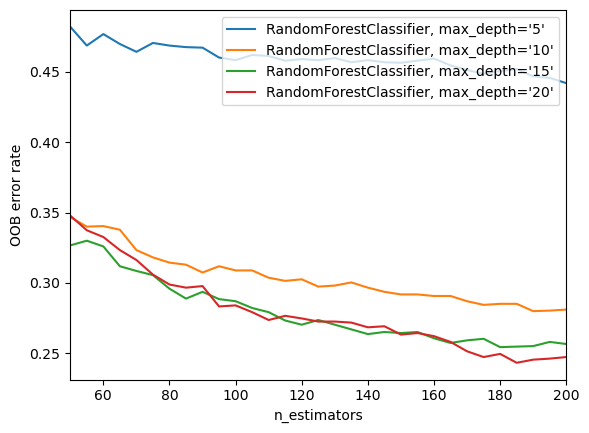

In [14]:
# Adjusted from:
# Author: Kian Ho <hui.kian.ho@gmail.com>
#         Gilles Louppe <g.louppe@gmail.com>
#         Andreas Mueller <amueller@ais.uni-bonn.de>
#
# License: BSD 3 Clause

from collections import OrderedDict
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

RANDOM_STATE = 123

# define numeric columns
numeric_cols = [num_col for num_col in df_stat_conn_features_ec.columns if 'EC' in num_col]
 
X = df_stat_conn_features_ec[numeric_cols]
Y = df_stat_conn_features_ec['diagnosis']

from sklearn.impute import SimpleImputer
imp_mean = SimpleImputer(missing_values=pd.NA, strategy='mean')
X = imp_mean.fit_transform(X)

from sklearn import preprocessing
le = preprocessing.LabelEncoder()
Y = le.fit_transform(Y)

# NOTE: Setting the `warm_start` construction parameter to `True` disables
# support for parallelized ensembles but is necessary for tracking the OOB
# error trajectory during training.
ensemble_clfs = [
    (
        "RandomForestClassifier, max_depth='5'",
        RandomForestClassifier(
            warm_start=True,
            oob_score=True,
            max_depth=5,
            random_state=RANDOM_STATE,
        ),
    ),
    (
        "RandomForestClassifier, max_depth='10'",
        RandomForestClassifier(
            warm_start=True,
            oob_score=True,
            max_depth=10,
            random_state=RANDOM_STATE,
        ),
    ),
    (
        "RandomForestClassifier, max_depth='15'",
        RandomForestClassifier(
            warm_start=True,
            oob_score=True,
            max_depth=15,
            random_state=RANDOM_STATE,
        ),
    ),
    (
        "RandomForestClassifier, max_depth='20'",
        RandomForestClassifier(
            warm_start=True,
            oob_score=True,
            max_depth=20,
            random_state=RANDOM_STATE,
        ),
    ),
    
]

# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

# Range of `n_estimators` values to explore.
min_estimators = 50
max_estimators = 200

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1, 5):
        clf.set_params(n_estimators=i)
        clf.fit(X, Y)

        # Record the OOB error for each `n_estimators=i` setting.
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))

# Generate the "OOB error rate" vs. "n_estimators" plot.
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
plt.show()

### EO features

Visualization of OOB error rate vs RF hyperparameters

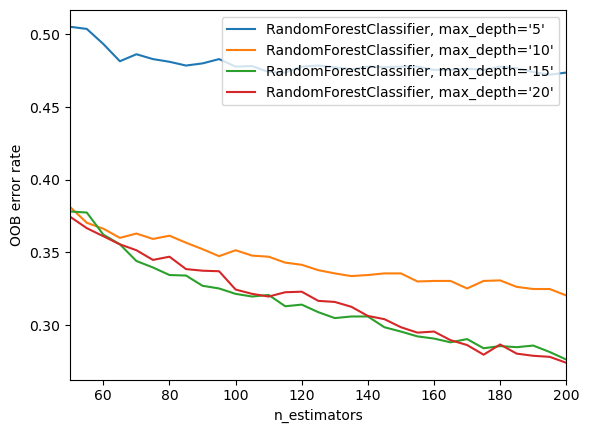

In [15]:
# Adjusted from:
# Author: Kian Ho <hui.kian.ho@gmail.com>
#         Gilles Louppe <g.louppe@gmail.com>
#         Andreas Mueller <amueller@ais.uni-bonn.de>
#
# License: BSD 3 Clause

from collections import OrderedDict
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

RANDOM_STATE = 123

# define numeric columns
numeric_cols = [num_col for num_col in df_stat_conn_features_eo.columns if 'EO' in num_col]
 
X = df_stat_conn_features_eo[numeric_cols]
Y = df_stat_conn_features_eo['diagnosis']

from sklearn.impute import SimpleImputer
imp_mean = SimpleImputer(missing_values=pd.NA, strategy='mean')
X = imp_mean.fit_transform(X)

from sklearn import preprocessing
le = preprocessing.LabelEncoder()
Y = le.fit_transform(Y)

# NOTE: Setting the `warm_start` construction parameter to `True` disables
# support for parallelized ensembles but is necessary for tracking the OOB
# error trajectory during training.
ensemble_clfs = [
    (
        "RandomForestClassifier, max_depth='5'",
        RandomForestClassifier(
            warm_start=True,
            oob_score=True,
            max_depth=5,
            random_state=RANDOM_STATE,
        ),
    ),
    (
        "RandomForestClassifier, max_depth='10'",
        RandomForestClassifier(
            warm_start=True,
            oob_score=True,
            max_depth=10,
            random_state=RANDOM_STATE,
        ),
    ),
    (
        "RandomForestClassifier, max_depth='15'",
        RandomForestClassifier(
            warm_start=True,
            oob_score=True,
            max_depth=15,
            random_state=RANDOM_STATE,
        ),
    ),
    (
        "RandomForestClassifier, max_depth='20'",
        RandomForestClassifier(
            warm_start=True,
            oob_score=True,
            max_depth=20,
            random_state=RANDOM_STATE,
        ),
    ),
    
]

# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

# Range of `n_estimators` values to explore.
min_estimators = 50
max_estimators = 200

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1, 5):
        clf.set_params(n_estimators=i)
        clf.fit(X, Y)

        # Record the OOB error for each `n_estimators=i` setting.
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))

# Generate the "OOB error rate" vs. "n_estimators" plot.
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
plt.show()